In [1]:
import glob
import pickle
import time
import gc
from collections import deque
import numpy as np
import pandas as pd
from music21 import converter, note, chord
import tensorflow as tf
from keras.utils import np_utils

from os import listdir


import numpy as np
import tensorflow as tf
from numpy import array
from tensorflow import keras
from tensorflow.keras import layers

ModuleNotFoundError: No module named 'music21'

## Processing the midi into a notes array (done)

In [ ]:
def midis_to_notes(midi_files: [str], output_filename: str) -> str:
    # This list will hold notes and chords from all songs appended together
    #   use deque to speedup
    allNotes = deque()

    print('Starting conversion of {} files'.format(len(midi_files)))

    gc.disable() # disable gc to speed up append
    prevtime = time.clock()
    for i, file in enumerate(midi_files):
        #print(i,file)
        midi = converter.parse(file)
        elements = midi.flat.notes

        for elem in elements:
            # Notes look like 'F#3'
            if isinstance(elem, note.Note):
                allNotes.append(elem.pitch.nameWithOctave)
            # Chords look like 'C4.E4.G#4'
            elif isinstance(elem, chord.Chord):
                allNotes.append('.'.join(pitch.nameWithOctave for pitch in elem.pitches))

        if (i+1) % 50 == 0:
            currtime = time.clock()
            print('Finished converting {} files, took {} seconds'.format(i+1, currtime - prevtime))
            prevtime = currtime
            gc.collect()
    gc.enable()

    print('Done converting midis to string array of notes and chords with len: {}'.format(len(allNotes)))

    # Saving the allNotes list to Google Drive cuz it takes bare time to complete
    filepath = 'data/{}.p'.format(output_filename)
    with open(filepath, 'wb') as pickleFile:
        pickle.dump(allNotes, pickleFile)
    
    return filepath

fileIterator = glob.glob('dataset/lofi/*.midi')
# Looks like the original fileIterator is too big? gets big slow downs around halfway
fileIt1 = fileIterator[:len(fileIterator)//2]
fileIt2 = fileIterator[len(fileIterator)//2:]

filePath1 = midis_to_notes(fileIt1, 'allNotes1')
filePath2 = midis_to_notes(fileIt2, 'allNotes2')


Starting conversion of 285 files


KeyboardInterrupt: ignored

##Processing the notes array into the numpy array format for the NN

In [ ]:
# Loading allNotes from file
allNotes = []

filePath1 = 'data/allNotes1.p'
filePath2 = 'data/allNotes2.p'

with open(filePath1, 'rb') as pickleFile1:
    allNotes += pickle.load(pickleFile1)
#with open(filePath2, 'rb') as pickleFile2:
#    allNotes += pickle.load(pickleFile2)

dataSize = 100000

allNotes = allNotes[:dataSize]

# Look at 10 previous notes to make a prediction
#   We can tune this parameter if needed, based on the length of 
#   chord progressions
seqLength = 10
print('Using sequence length of {}'.format(seqLength))

pitchSet = sorted(set(allNotes))
numPitches = len(pitchSet)
# here pitches are either notes or chords
#   they are sorted lexicographically, so a chord 'C4.E4' will come after a
#   note 'C4'
print('Identified {} pitches'.format(numPitches))

# Map each note/chord to a number normalized to (0,1)
pitchMapping = dict((note, number) for (number, note) in enumerate(pitchSet))

networkInput = []
networkOutput = []

print('Starting sequencing of {} notes'.format(len(allNotes)))
for i in range(0, len(allNotes)- seqLength):
    sequenceIn = allNotes[i:i+seqLength]
    predictionOut = allNotes[i+seqLength]

    networkInput.append([pitchMapping[note] for note in sequenceIn])
    networkOutput.append(pitchMapping[predictionOut])

    if (i+1) % 400000 == 0:
        print('Finished making {} sequences'.format(i+1))

# Comment this out so we can do this in the cross validation loop instead
#numSeqs = len(networkInput)
# reshape input to match the LSTM layer format
#networkInput = np.reshape(networkInput, (numSeqs, seqLength, 1))
#networkInput = networkInput / numPitches

#networkOutput = np_utils.to_categorical(networkOutput)

networkInput = np.array(networkInput)
networkOutput = np.array(networkOutput)

print('Done preparing network input and output')
# Now data should be in the desired format for the NN

#print(networkInput)

Using sequence length of 10
Identified 4896 pitches
Starting sequencing of 100000 notes
Done preparing network input and output


In [ ]:
print(networkOutput[3])

164


# Create the model and its layers

In [ ]:
numSeqs = len(networkInput)
# reshape input to match the LSTM layer format
networkInputShaped = np.reshape(networkInput, (numSeqs, seqLength, 1))
networkInputShaped = networkInputShaped / numPitches

networkOutputShaped = np_utils.to_categorical(networkOutput)


model = keras.models.Sequential()
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(
    512,
    input_shape=(networkInputShaped.shape[1], networkInputShaped.shape[2]),
    return_sequences=True
))
model.add(layers.Dense(256))
model.add(layers.Dense(256))
model.add(layers.LSTM(512, return_sequences=True))
model.add(layers.Dense(256))
model.add(layers.LSTM(512))
model.add(layers.Dense(numPitches))
model.add(layers.Dense(numPitches))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


# Fitting model from scratch


In [ ]:
num_epochs = 10

filepath = "data/weights/" + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=1,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]


history = model.fit(networkInputShaped, networkOutputShaped, epochs=num_epochs, batch_size=64, callbacks=callbacks_list)



# modelFilepath = '/content/drive/My Drive/RNN_lofi/trained_model'
# pickle.dump(model, open(modelFilepath, 'wb'))

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 4.4475
Epoch 00001: loss improved from inf to 4.44748, saving model to /content/drive/My Drive/RNN_lofi/weights/weights-improvement-01-4.4475-bigger.hdf5
157/157 [==============================] - 58s 368ms/step - loss: 4.4475
Epoch 2/10
157/157 [==============================] - ETA: 0s - loss: 4.2713
Epoch 00002: loss improved from 4.44748 to 4.27126, saving model to /content/drive/My Drive/RNN_lofi/weights/weights-improvement-02-4.2713-bigger.hdf5
157/157 [==============================] - 57s 365ms/step - loss: 4.2713
Epoch 3/10
157/157 [==============================] - ETA: 0s - loss: 4.1427
Epoch 00003: loss improved from 4.27126 to 4.14265, saving model to /content/drive/My Drive/RNN_lofi/weights/weights-improvement-03-4.1427-bigger.hdf5
157/157 [==============================] - 57s 363ms/step - loss: 4.1427
Epoch 4/10
157/157 [==============================] - ETA: 0s - loss: 3.9791
Epoch 00004: loss improv

# Generating model from previously trained weights

In [ ]:
# put the file path in manually
load_filepath = "data/weights/" + "weights-improvement-10-2.9348-bigger.hdf5"
loaded_weights = model.load_weights(filepath=load_filepath)
model.summary()
model.get_weights()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 10, 256)           0         
_________________________________________________________________
dense_15 (Dense)             (None, 10, 256)           65792     
_________________________________________________________________
lstm_16 (LSTM)               (None, 10, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 10, 256)           65792     
_________________________________________________________________
lstm_17 (LSTM)               (None, 512)              

[array([[-0.13089962, -0.11227641, -0.09778985, ...,  0.02259778,
         -0.04520895, -0.00553933]], dtype=float32),
 array([[-1.72691002e-01, -1.52132034e-01, -9.79923159e-02, ...,
         -5.17972112e-02, -8.67688796e-05, -4.02270369e-02],
        [ 2.13064387e-01,  1.41610116e-01,  1.19628385e-01, ...,
          3.65285925e-03,  2.05319859e-02, -1.03352591e-02],
        [ 1.15018167e-01,  1.12442628e-01,  6.68380782e-02, ...,
         -2.11787838e-02, -4.04455960e-02, -1.38373422e-02],
        ...,
        [-4.63307127e-02, -1.13754593e-01,  1.65073816e-02, ...,
         -3.78160179e-02,  1.19447056e-02,  3.36872451e-02],
        [ 1.14690080e-01,  1.42341942e-01,  3.23881283e-02, ...,
         -3.25296856e-02,  1.06513342e-02,  3.73220886e-03],
        [-1.13906406e-01, -2.61619203e-02, -1.03424884e-01, ...,
          2.47345679e-02, -1.98463313e-02, -2.29486171e-02]], dtype=float32),
 array([-0.02001613, -0.02538976, -0.00484791, ..., -0.04571848,
        -0.04742846, -0.019414

# Generate Music with Model

In [ ]:
from music21 import converter, instrument, note, chord, stream

start = 0
int_to_note = dict((number, note) for number, note in enumerate(pitchSet))
pattern = networkInput[start]
prediction_output = []

# generate 100 notes
for note_index in range(100):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(numPitches)
    prediction = model.predict(prediction_input, verbose=1)

    result = int_to_note[np.argmax(prediction)]
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]


offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    print(pattern, end=' ')
    # pattern is a chord
    if '.' in pattern:
        note_names = pattern.split('.')
        notes = []
        for note_name in note_names:
            new_note = note.Note(note_name)
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        new_chord.duration.quarterLength = 1
        output_notes.append(new_chord)
    # pattern is a note
    else:
        # If same note is repeated, extend the first note instead
        if output_notes and isinstance(output_notes[-1], note.Note) \
           and pattern == output_notes[-1].nameWithOctave:
            output_notes[-1].duration.quarterLength += 0.5
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5
print('\n')

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output.mid')

B-4 G#3 G#3 B3 B3 E4 E4 A4 A4 D4 F#2 A4 A4 E-4 F#2.C#2 A4 A4 C5 F#2.C#2 A4 A4 A3 F#2.C#2 A4 A4 C4 G1 E4 F#2 C2 B2 E4 E4 G4 B4 F#2 E2 E2 E2 B2 B3 G3 G3 E2.F#2 E3 G3 B3 D2 E2 E2 E2 E3.G3 B2 B3 G3 G3 E2.F#2 E3 G3 B3 D2 E2 E2 E2 E3.G3 B2 B3 G3 G3 E2.F#2 E3 G3 B3 D2 E2 E2 E2 E3.G3 B2 B3 G3 G3 E2.F#2 E3 G3 B3 D2 E2 E2 E2 E3.G3 B2 B3 G3 G3 E2.F#2 E3 G3 B3 D2 



'test_output.mid'

## Play the midi

In [ ]:
# https://gist.github.com/korakot/a0c6b0120bb75d48588aec27030b3325
! apt install fluidsynth

from IPython.display import Audio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [ ]:
! fluidsynth -ni font.sf2 test_output.mid -F output.wav -r 44100

Audio('output.wav')

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

fluidsynth: warning: No preset found on channel 9 [bank=128 prog=0]
Rendering audio to file 'output.wav'..


# Plotting Results

## Hyperparameter Tuning for number of layers (Bruce)

In [ ]:
# For Bruce to Use
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import StratifiedKFold
import numpy
from math import fsum

# fix random seed for reproducibility
seed = 3
numpy.random.seed(seed)

# define the kFold
n_folds = 5
fold_num = 1
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

cvs_scores = []

for train, test in kfold.split(networkInput, networkOutput):
  # reshape input to match the LSTM layer format
  print("FOLD NUMBER: " + str(fold_num))
  fold_num += 1
  networkInputTrain = np.reshape(networkInput[train], (len(networkInput[train]), seqLength, 1))
  networkInputTrain = networkInputTrain / numPitches

  networkOutputTrain = np_utils.to_categorical(networkOutput[train], num_classes=numPitches)

  networkInputTest = np.reshape(networkInput[test], (len(networkInput[test]), seqLength, 1))
  networkInputTest = networkInputTest / numPitches

  networkOutputTest = np_utils.to_categorical(networkOutput[test], num_classes=numPitches)

  model = Sequential()
  model.add(LSTM(
      512,
      input_shape=(networkInputTrain.shape[1], networkInputTrain.shape[2]),
      return_sequences=True
  ))
  model.add(Dropout(0.1))
  model.add(Dense(256))
  model.add(Dense(256))
  model.add(LSTM(512, return_sequences=True))
  model.add(Dense(256))
  model.add(LSTM(512, return_sequences=True))
  model.add(Dense(256))
  model.add(LSTM(512))
  model.add(Dense(numPitches))
  model.add(Dense(numPitches))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  model.fit(networkInputTrain, networkOutputTrain, epochs=30, batch_size=28, verbose=1)

  scores = model.evaluate(networkInputTest, networkOutputTest, verbose=1)
  cvs_scores.append(scores[1] * 100)

print("AVERAGE SCORE: " + str(fsum(cvs_scores) / len(cvs_scores)))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


FOLD NUMBER: 1
Epoch 1/30
286/286 [==============================] - 139s 485ms/step - loss: 4.5440 - accuracy: 0.0856
Epoch 2/30
286/286 [==============================] - 140s 489ms/step - loss: 4.3830 - accuracy: 0.0887
Epoch 3/30
286/286 [==============================] - 141s 492ms/step - loss: 4.2983 - accuracy: 0.1030
Epoch 4/30
286/286 [==============================] - 141s 492ms/step - loss: 4.1915 - accuracy: 0.1275
Epoch 5/30
286/286 [==============================] - 140s 489ms/step - loss: 4.1058 - accuracy: 0.1455
Epoch 6/30
286/286 [==============================] - 140s 488ms/step - loss: 4.0031 - accuracy: 0.1612
Epoch 7/30
286/286 [==============================] - 141s 492ms/step - loss: 3.8464 - accuracy: 0.1877
Epoch 8/30
286/286 [==============================] - 141s 492ms/step - loss: 3.6489 - accuracy: 0.2177
Epoch 9/30
286/286 [==============================] - 142s 498ms/step - loss: 3.4820 - accuracy: 0.2570
Epoch 10/30
286/286 [============================

## Hyperparameter Tuning for epochs and batch size (Sara)

In [ ]:
# For Sara to Use
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from sklearn.model_selection import StratifiedKFold
import numpy
from math import fsum

# fix random seed for reproducibility
seed = 3
numpy.random.seed(seed)

# define the kFold
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

batchSizes = [16, 100, 112, 124]
for batch_size in batchSizes:
  cvs_scores = []

  for train, test in kfold.split(networkInput, networkOutput):
    # reshape input to match the LSTM layer format
    networkInputTrain = np.reshape(networkInput[train], (len(networkInput[train]), seqLength, 1))
    networkInputTrain = networkInputTrain / numPitches

    networkOutputTrain = np_utils.to_categorical(networkOutput[train], num_classes=numPitches)

    networkInputTest = np.reshape(networkInput[test], (len(networkInput[test]), seqLength, 1))
    networkInputTest = networkInputTest / numPitches

    networkOutputTest = np_utils.to_categorical(networkOutput[test], num_classes=numPitches)

    model = Sequential()
    model.add(LSTM(
        256,
        input_shape=(networkInputTrain.shape[1], networkInputTrain.shape[2]),
        return_sequences=True
    ))
    model.add(Dense(256))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dense(256))
    model.add(LSTM(512))
    model.add(Dense(numPitches))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(networkInputTrain, networkOutputTrain, epochs=10, batch_size=batch_size, verbose=1)

    scores = model.evaluate(networkInputTest, networkOutputTest, verbose=1)
    cvs_scores.append(scores[1] * 100)

  print("AVERAGE SCORE for batch size" + str(batch_size) + ": " + str(fsum(cvs_scores) / len(cvs_scores)))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/10
500/500 [==============================] - 97s 193ms/step - loss: 4.4340 - accuracy: 0.0897
Epoch 2/10
500/500 [==============================] - 99s 198ms/step - loss: 4.2393 - accuracy: 0.1160
Epoch 3/10
500/500 [==============================] - 99s 199ms/step - loss: 4.1026 - accuracy: 0.1438
Epoch 4/10
500/500 [==============================] - 99s 198ms/step - loss: 3.9576 - accuracy: 0.1679
Epoch 5/10
500/500 [==============================] - 101s 202ms/step - loss: 3.7344 - accuracy: 0.2087
Epoch 6/10
500/500 [==============================] - 100s 200ms/step - loss: 3.4518 - accuracy: 0.2589
Epoch 7/10
500/500 [==============================] - 99s 198ms/step - loss: 3.1588 - accuracy: 0.3164
Epoch 8/10
500/500 [==============================] - 98s 197ms/step - loss: 2.8672 - accuracy: 0.3741
Epoch 9/10
500/500 [==============================] - 98s 196ms/step - loss: 2.5874 - accuracy: 0.4298
Epoch 10/10
63/63 [==============================] - 4s 56ms/step - los

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/10
80/80 [==============================] - 33s 418ms/step - loss: 4.5056 - accuracy: 0.0787
Epoch 2/10
80/80 [==============================] - 34s 424ms/step - loss: 4.3212 - accuracy: 0.0936
Epoch 3/10
80/80 [==============================] - 34s 424ms/step - loss: 4.2270 - accuracy: 0.1104
Epoch 4/10
80/80 [==============================] - 34s 430ms/step - loss: 4.1412 - accuracy: 0.1239
Epoch 5/10
80/80 [==============================] - 35s 443ms/step - loss: 4.0048 - accuracy: 0.1426
Epoch 6/10
80/80 [==============================] - 36s 446ms/step - loss: 3.8619 - accuracy: 0.1609
Epoch 7/10
80/80 [==============================] - 36s 456ms/step - loss: 3.7083 - accuracy: 0.1824
Epoch 8/10
80/80 [==============================] - 37s 467ms/step - loss: 3.5348 - accuracy: 0.2082
Epoch 9/10
80/80 [==============================] - 38s 470ms/step - loss: 3.3354 - accuracy: 0.2386
Epoch 10/10
63/63 [==============================] - 4s 58ms/step - loss: 3.5731 - accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/10
72/72 [==============================] - 37s 520ms/step - loss: 4.5175 - accuracy: 0.0856
Epoch 2/10
72/72 [==============================] - 38s 530ms/step - loss: 4.3093 - accuracy: 0.0983
Epoch 3/10
72/72 [==============================] - 38s 534ms/step - loss: 4.2190 - accuracy: 0.1089
Epoch 4/10
72/72 [==============================] - 37s 513ms/step - loss: 4.1398 - accuracy: 0.1245
Epoch 5/10
72/72 [==============================] - 37s 512ms/step - loss: 4.0347 - accuracy: 0.1378
Epoch 6/10
72/72 [==============================] - 37s 512ms/step - loss: 3.9048 - accuracy: 0.1547
Epoch 7/10
72/72 [==============================] - 38s 524ms/step - loss: 3.7631 - accuracy: 0.1739
Epoch 8/10
72/72 [==============================] - 38s 522ms/step - loss: 3.6114 - accuracy: 0.1947
Epoch 9/10
72/72 [==============================] - 35s 490ms/step - loss: 3.4259 - accuracy: 0.2255
Epoch 10/10
63/63 [==============================] - 4s 62ms/step - loss: 3.8133 - accuracy

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Epoch 1/10
65/65 [==============================] - 32s 494ms/step - loss: 4.5105 - accuracy: 0.0795
Epoch 2/10
65/65 [==============================] - 32s 493ms/step - loss: 4.3192 - accuracy: 0.0962
Epoch 3/10
65/65 [==============================] - 32s 489ms/step - loss: 4.2312 - accuracy: 0.1049
Epoch 4/10
65/65 [==============================] - 32s 491ms/step - loss: 4.1592 - accuracy: 0.1177
Epoch 5/10
65/65 [==============================] - 32s 496ms/step - loss: 4.0787 - accuracy: 0.1294
Epoch 6/10
65/65 [==============================] - 32s 493ms/step - loss: 3.9546 - accuracy: 0.1453
Epoch 7/10
65/65 [==============================] - 32s 494ms/step - loss: 3.8185 - accuracy: 0.1643
Epoch 8/10
65/65 [==============================] - 36s 555ms/step - loss: 3.6699 - accuracy: 0.1861
Epoch 9/10
65/65 [==============================] - 32s 495ms/step - loss: 3.5119 - accuracy: 0.2043
Epoch 10/10
63/63 [==============================] - 3s 54ms/step - loss: 3.7349 - accuracy

In [ ]:
# For Sara to Use
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from sklearn.model_selection import StratifiedKFold
import numpy
from math import fsum

# fix random seed for reproducibility
seed = 3
numpy.random.seed(seed)

# define the kFold
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

batchSizes = [16, 100, 112, 124]
for batch_size in batchSizes:
  cvs_scores = []

  for train, test in kfold.split(networkInput, networkOutput):
    # reshape input to match the LSTM layer format
    networkInputTrain = np.reshape(networkInput[train], (len(networkInput[train]), seqLength, 1))
    networkInputTrain = networkInputTrain / numPitches

    networkOutputTrain = np_utils.to_categorical(networkOutput[train], num_classes=numPitches)

    networkInputTest = np.reshape(networkInput[test], (len(networkInput[test]), seqLength, 1))
    networkInputTest = networkInputTest / numPitches

    networkOutputTest = np_utils.to_categorical(networkOutput[test], num_classes=numPitches)

    model = Sequential()
    model.add(LSTM(
        256,
        input_shape=(networkInputTrain.shape[1], networkInputTrain.shape[2]),
        return_sequences=True
    ))
    model.add(Dense(256))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dense(256))
    model.add(LSTM(512))
    model.add(Dense(numPitches))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(networkInputTrain, networkOutputTrain, epochs=10, batch_size=batch_size, verbose=1)

    scores = model.evaluate(networkInputTest, networkOutputTest, verbose=1)
    cvs_scores.append(scores[1] * 100)

  print("AVERAGE SCORE for batch size" + str(batch_size) + ": " + str(fsum(cvs_scores) / len(cvs_scores)))


## Hyperparameter Tuning for layer size/dropout size (Danny)

In [ ]:
# For Danny to Use
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import StratifiedKFold
import numpy
from math import fsum

# fix random seed for reproducibility
seed = 3
numpy.random.seed(seed)

# define the kFold
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

cvs_scores = []

num_epochs = 10

for i, (train, test) in enumerate(kfold.split(networkInput, networkOutput)):
    # reshape input to match the LSTM layer format
    networkInputTrain = np.reshape(networkInput[train], (len(networkInput[train]), seqLength, 1))
    networkInputTrain = networkInputTrain / numPitches

    networkOutputTrain = np_utils.to_categorical(networkOutput[train], num_classes=numPitches)

    networkInputTest = np.reshape(networkInput[test], (len(networkInput[test]), seqLength, 1))
    networkInputTest = networkInputTest / numPitches

    networkOutputTest = np_utils.to_categorical(networkOutput[test], num_classes=numPitches)

    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(networkInputTrain.shape[1], networkInputTrain.shape[2]),
        return_sequences=True
    ))
    model.add(Dropout(0.2)) # we need to ajdust this one and get numbers
    model.add(Dense(256))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dense(256))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dense(256))
    model.add(LSTM(512))
    model.add(Dense(numPitches))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    model.fit(networkInputTrain, networkOutputTrain, epochs=30, batch_size=28, verbose=1)

    scores = model.evaluate(networkInputTest, networkOutputTest, verbose=1)
    cvs_scores.append(scores[1] * 100)

    filepath = 'data/weights/' \
        + 'danny_weights_good_it{}_acc{}.hdf5'.format(i, cvs_scores[-1])
    model.save_weights(filepath)

avgScore = str(fsum(cvs_scores) / len(cvs_scores))
scoreStr = 'Good version {}: {}\n'.format(dropoutRate, avgScore)
with open('data/weights/danny_results.txt', 'a+') as resultsFile:
    resultsFile.write(scoreStr)

print(scoreStr)





NameError: ignored

## Plot hyperparameter tuning results (Danny)

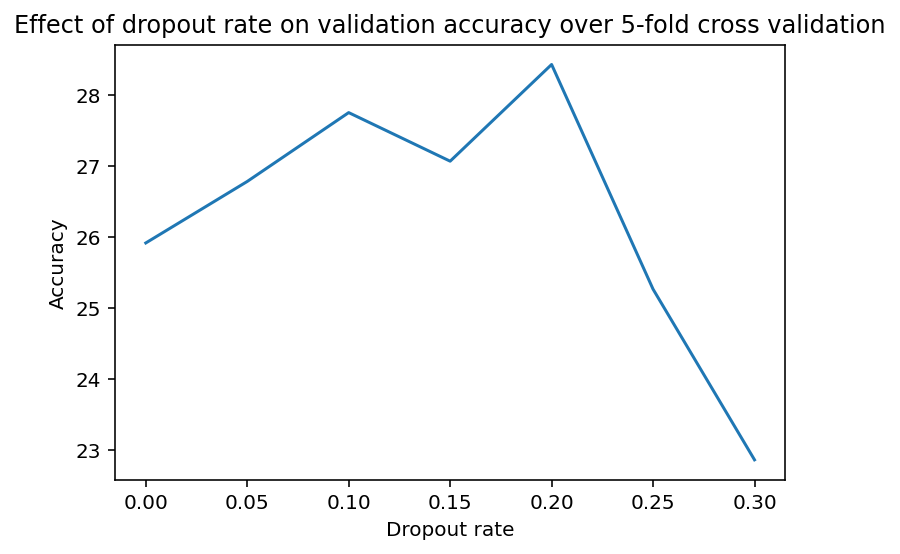

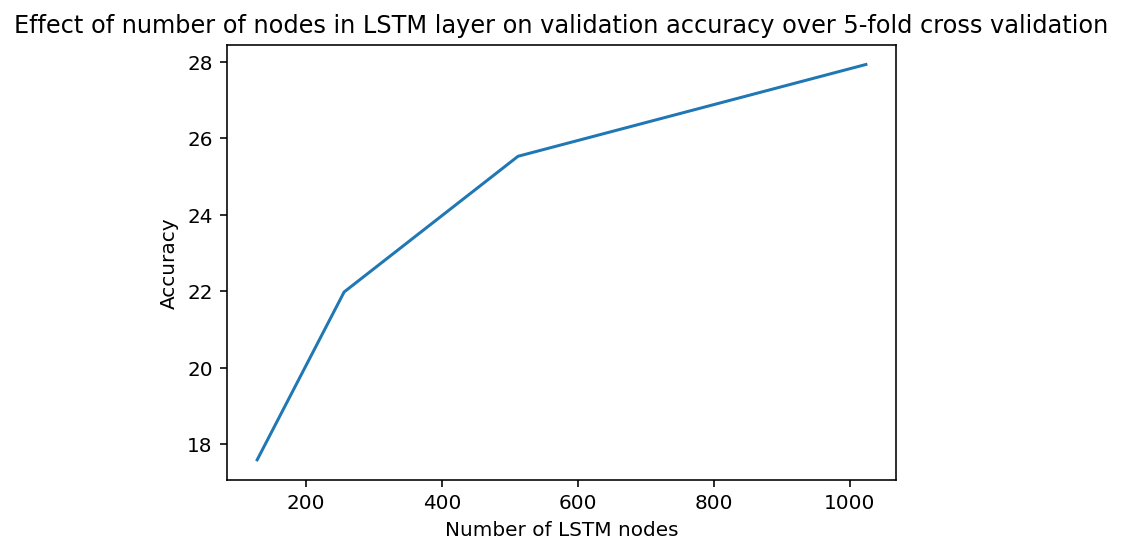

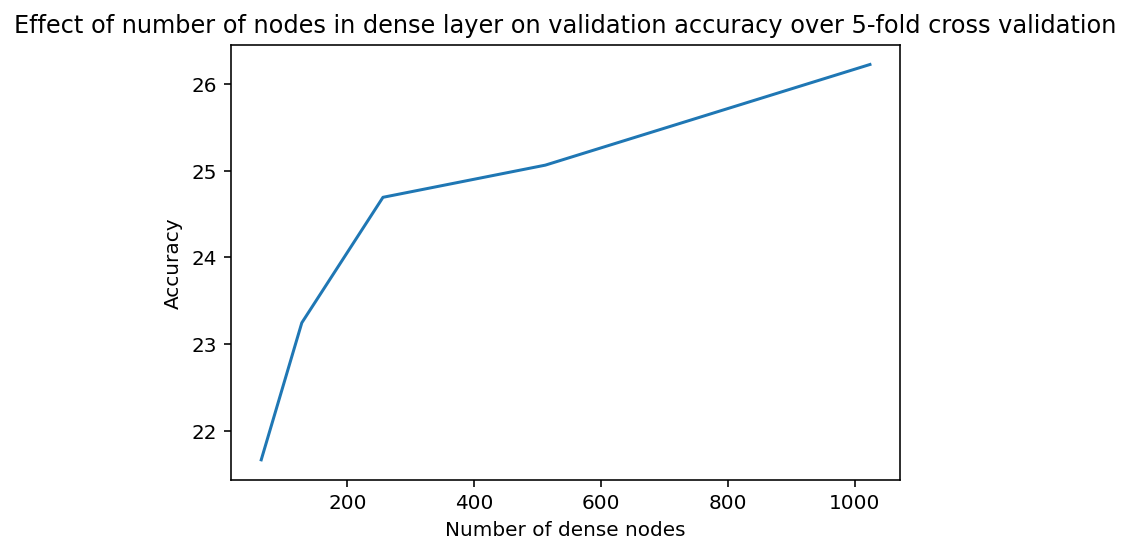

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

dropout = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
dropoutAcc = [25.915915966033936, 26.781781911849976, \
              27.751084566116333, 27.067067176103592, \
              28.428428769111633, 25.265265256166458, 22.862862944602966]

plt.plot(dropout, dropoutAcc)
plt.title('Effect of dropout rate on validation accuracy over 5-fold cross validation')
plt.xlabel('Dropout rate')
plt.ylabel('Accuracy')
plt.show()

lstmNumNodes = [128, 256, 512, 1024]
lstmNumNodesAcc = [17.58758783340454, 21.976976841688156, \
                   25.52552531162898, 27.925425246357918] 

plt.plot(lstmNumNodes, lstmNumNodesAcc)
plt.title('Effect of number of nodes in LSTM layer on validation accuracy over 5-fold cross validation')
plt.xlabel('Number of LSTM nodes')
plt.ylabel('Accuracy')
plt.show()

denseNumNodes = [64, 128, 256, 512, 1024]
denseNumNodesAcc = [21.661661565303802, 23.24324294924736, \
                    24.69135771195094, 25.062562376260757, 26.224224090576172]

plt.plot(denseNumNodes, denseNumNodesAcc)
plt.title('Effect of number of nodes in dense layer on validation accuracy over 5-fold cross validation')
plt.xlabel('Number of dense nodes')
plt.ylabel('Accuracy')
plt.show()

## Good copy

In [ ]:
# For Danny to Use
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import StratifiedKFold
import numpy
from math import fsum

networkInputGood = np.reshape(networkInput, (len(networkInput), seqLength, 1))
networkInputGood = networkInputGood / numPitches

networkOutputGood = np_utils.to_categorical(networkOutput, num_classes=numPitches)

model = Sequential()
model.add(LSTM(
    512,
    input_shape=(networkInputGood.shape[1], networkInputGood.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.2)) # we need to ajdust this one and get numbers
model.add(Dense(256))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(256))
model.add(LSTM(512, return_sequences=True))
model.add(Dense(256))
model.add(LSTM(512))
model.add(Dense(numPitches))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

filepatha = "data/weights/" + "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepatha, monitor='loss', 
    verbose=1,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]

model.fit(networkInputGood, networkOutputGood, epochs=30, batch_size=28, verbose=1, callbacks=callbacks_list)



filepath = 'data/weights/' \
    + 'danny_weights_good.hdf5'
model.save_weights(filepath)

print("done good copy!")




Epoch 1/30
3572/3572 [==============================] - ETA: 0s - loss: 5.7249 - accuracy: 0.0556
Epoch 00001: loss improved from inf to 5.72495, saving model to /content/drive/My Drive/RNN_lofi/weights/weights-improvement-01-5.7249-bigger.hdf5
3572/3572 [==============================] - 1885s 528ms/step - loss: 5.7249 - accuracy: 0.0556
Epoch 2/30
2966/3572 [=======================>......] - ETA: 5:25 - loss: 5.6766 - accuracy: 0.0558

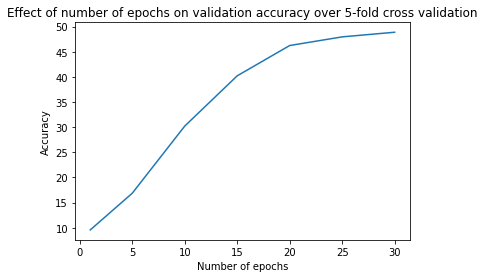

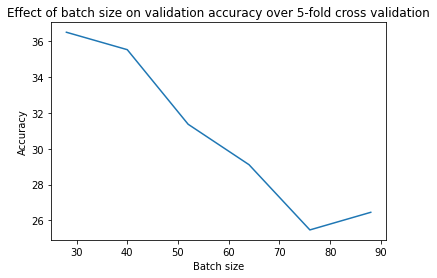

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = [1, 5, 10, 15, 20, 25, 30]
epochAccuracy = [9.559559524059296, 16.85685694217682, 30.21021008491516, 40.21021008491516, 46.23623549938202, 47.95795798301697, 48.87887954711914]

plt.plot(epochs, epochAccuracy)
plt.title('Effect of number of epochs on validation accuracy over 5-fold cross validation')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.show()

batchSizes = [28, 40, 52, 64, 76, 88]
batchSizeAccuracy = [36.48648738861084, 35.515515208244324, 31.361361145973206, 29.10910964012146, 25.475475192070007, 26.456456184387207]

plt.plot(batchSizes, batchSizeAccuracy)
plt.title('Effect of batch size on validation accuracy over 5-fold cross validation')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.show()
